# DSC180A Project 1

### Week 3

Conduct EDA on the Data

In [1]:
import openpyxl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import folium
from folium import plugins
from folium.plugins import HeatMap, MarkerCluster
from IPython.display import IFrame
import geopandas as gpd
from shapely import wkt

In [2]:
# Load the Excel files into Pandas DataFrames
gis_weather_station = pd.read_csv('./data/gis_weatherstation_shape_2024_10_04.csv')
station_summary_snapshot = pd.read_csv('./data/src_wings_meteorology_station_summary_snapshot_2023_08_02.csv')
windspeed_snapshot = pd.read_csv('./data/src_wings_meteorology_windspeed_snapshot_2023_08_02.csv')

In [3]:
gis_weather_station.head()

,objectid,weatherstationcode,weatherstationname,scadartuid,structureid,nwszone,district,thomasbrospagegrid,constructionstatus,creationuser,...,elevation,twinguid,hftd,zone1idc,hftdidc,gdb_geomattr_data,globalid,shape,shape_srid,snapshot_date
0,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,72,NaN,1,N,N,NaN,{ED5DE7F2-F63A-41EA-BA80-9F71495334A3},POINT (1540299.9388 12029375.0425),4431,10/4/2024
1,2,CCR,Cuca Ranch,1915.0,Z118027,Mountain-258,3.0,1052-A5,A,seu_gis_elec,...,2513,NaN,3,N,Y,NaN,{82759049-437B-4A5C-8796-10C8D7098C5B},POINT (1667010.27856 12088881.1767),4431,10/4/2024
2,3,CES,Country Estates,1995.0,Z416611,Inland Valley-250,3.0,1153-G7,A,seu_gis_elec,...,1822,NaN,3,N,Y,NaN,{6A3A6DAD-6CD1-43B7-A0FE-72A52A46A4F7},POINT (1703876.2967 11989778.75946),4431,10/4/2024
3,208,ROV,Rim of the Valley,4818.0,Z416170,Inland Valley-250,3.0,1071-B1,A,gwharris,...,1533,NaN,3,N,Y,NaN,{AD1AEA81-BC74-4954-8D25-421C79F40D88},POINT (1646528.56915 12083236.45575),4431,10/4/2024
4,5,CHO,Chollas Lake,5182.0,P970712,Inland Valley-250,1.0,1270-C7,A,seu_gis_elec,...,448,NaN,1,N,N,NaN,{1294A90A-9558-458E-8EA5-9D15B2A16D8D},POINT (1619955.10724 11883209.4286),4431,10/4/2024


In [4]:
gis_weather_station = gis_weather_station.drop_duplicates(subset=['weatherstationcode'], keep='first')

In [5]:
station_summary_snapshot.head()

,station,vri,alert,max_gust,99th,95th,snapshot_date
0,AMO,H,35,40,32,24,2023-08-02
1,ANE,M,35,43,32,25,2023-08-02
2,ARH,L,40,46,40,31,2023-08-02
3,AVO,H,35,43,29,24,2023-08-02
4,AVY,L,45,62,53,40,2023-08-02


In [6]:
windspeed_snapshot.head()

,date,wind_speed,station,snapshot_date
0,9/14/2012,19.0,AMO,8/2/2023
1,9/15/2012,20.0,AMO,8/2/2023
2,10/14/2012,16.0,AMO,8/2/2023
3,10/26/2012,23.0,AMO,8/2/2023
4,10/27/2012,15.0,AMO,8/2/2023


In [7]:
print(f"gis weather station shape: {gis_weather_station.shape}")
print(f"station summary shape: {station_summary_snapshot.shape}")
print(f"windspeed snapshot shape: {windspeed_snapshot.shape}")

gis weather station shape: (221, 27)
station summary shape: (216, 7)
windspeed snapshot shape: (38664, 4)


In [8]:
#Check null data for gis weather station
gis_weather_station.isna().sum()

objectid                0
weatherstationcode      0
weatherstationname      0
scadartuid              1
structureid             5
nwszone                 0
district                3
thomasbrospagegrid      2
constructionstatus      0
creationuser            0
datecreated             0
datemodified            3
lastuser                3
structureguid           6
symbolrotation          0
latitude                0
longitude               0
elevation               0
twinguid              221
hftd                    0
zone1idc                0
hftdidc                 0
gdb_geomattr_data     221
globalid                0
shape                   0
shape_srid              0
snapshot_date           0
dtype: int64

In [9]:
#Check null data for station summary
station_summary_snapshot.isna().sum()

station           0
vri              10
alert             0
max_gust          0
99th              0
95th              0
snapshot_date     0
dtype: int64

In [10]:
#Check null data for wind speed summary
windspeed_snapshot.isna().sum()

date                0
wind_speed       8724
station             0
snapshot_date       0
dtype: int64

In [11]:
station_summary_snapshot['vri'].unique().tolist()

['H', 'M', 'L', nan]

In [12]:
station_stats = station_summary_snapshot.drop(['station', 'snapshot_date'], axis=1)[station_summary_snapshot['vri'].notna()].groupby('vri').agg(['mean', 'median'])
station_stats.index = pd.Categorical(station_stats.index, categories=['L', 'M', 'H'], ordered=True)
station_stats = station_stats.sort_index()
station_stats

alert          max_gust              99th              95th       
        mean median       mean median       mean median       mean median
L  40.797619   42.5  53.892857   53.5  43.238095   43.5  33.880952   34.0
M  38.968085   37.5  49.468085   50.0  39.191489   39.5  30.968085   31.0
H  35.357143   35.0  44.571429   43.5  35.250000   34.5  27.928571   27.5

In [13]:
def impute_vri(dataset, descriptive_data, column, stats):
    ser = descriptive_data[column][stats]
    low_threshold = (ser.loc['L'] + ser.loc['M']) / 2
    medium_threshold = (ser.loc['M'] + ser.loc['H']) / 2
    
    if dataset > low_threshold:
        return 'L'
    elif dataset > medium_threshold:
        return 'M'
    else:
        return 'H'
    

station_summary_snapshot['vri'] = station_summary_snapshot.apply(lambda row: impute_vri(row['alert'], station_stats, 'alert', 'mean') 
                     if pd.isnull(row['vri']) else row['vri'], axis=1)

station_summary_snapshot['vri'].isna().sum()

0

In [14]:
windspeed_snapshot[windspeed_snapshot['wind_speed'].isna()].groupby('station').count().sort_values('date', ascending=True)

,date,wind_speed,snapshot_date
station,,,
WYN,1,0,1
SPV,1,0,1
MLG,1,0,1
MGD,1,0,1
LFR,1,0,1
...,...,...,...
BOB,134,0,134
GAV,134,0,134
DAM,136,0,136


In [15]:
windspeed_snapshot.sort_values(by='wind_speed', ascending=False)

,date,wind_speed,station,snapshot_date
2180,12/14/2013,611.0,BOC,8/2/2023
30293,4/30/2014,101.0,SIL,8/2/2023
30394,12/3/2020,94.0,SIL,8/2/2023
13732,12/17/2019,91.0,HHC,8/2/2023
30350,1/28/2018,89.0,SIL,8/2/2023
...,...,...,...,...
37886,12/31/2018,NaN,WST,8/2/2023
38000,11/16/2014,NaN,WSY,8/2/2023
38001,11/17/2014,NaN,WSY,8/2/2023
38002,11/18/2014,NaN,WSY,8/2/2023


In [16]:
#Dropping outlier data
windspeed_snapshot = windspeed_snapshot[(windspeed_snapshot['wind_speed'] < max(windspeed_snapshot['wind_speed']))]
windspeed_snapshot.sort_values(by='wind_speed', ascending=False)

,date,wind_speed,station,snapshot_date
30293,4/30/2014,101.0,SIL,8/2/2023
30394,12/3/2020,94.0,SIL,8/2/2023
13732,12/17/2019,91.0,HHC,8/2/2023
30350,1/28/2018,89.0,SIL,8/2/2023
30343,12/7/2017,88.0,SIL,8/2/2023
...,...,...,...,...
10511,12/20/2019,6.0,ECJ,8/2/2023
3757,12/24/2022,6.0,CAP,8/2/2023
963,11/23/2015,6.0,BFD,8/2/2023
28429,12/23/2020,6.0,RIO,8/2/2023


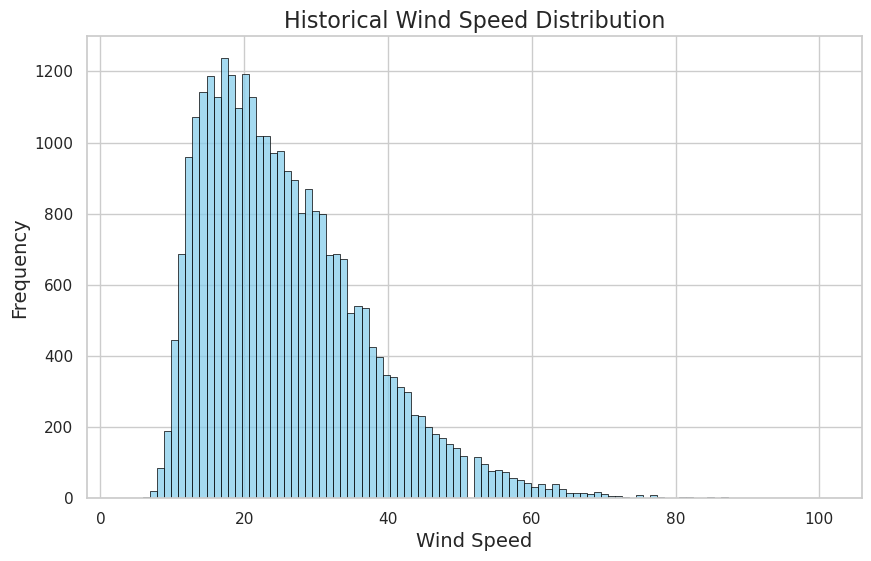

Wind Speed data is Right Skewed


In [17]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.histplot(windspeed_snapshot['wind_speed'].dropna(), bins=100, kde=False, color='skyblue', edgecolor='black')

plt.title('Historical Wind Speed Distribution', fontsize=16)
plt.xlabel('Wind Speed', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.show()
print('Wind Speed data is Right Skewed')

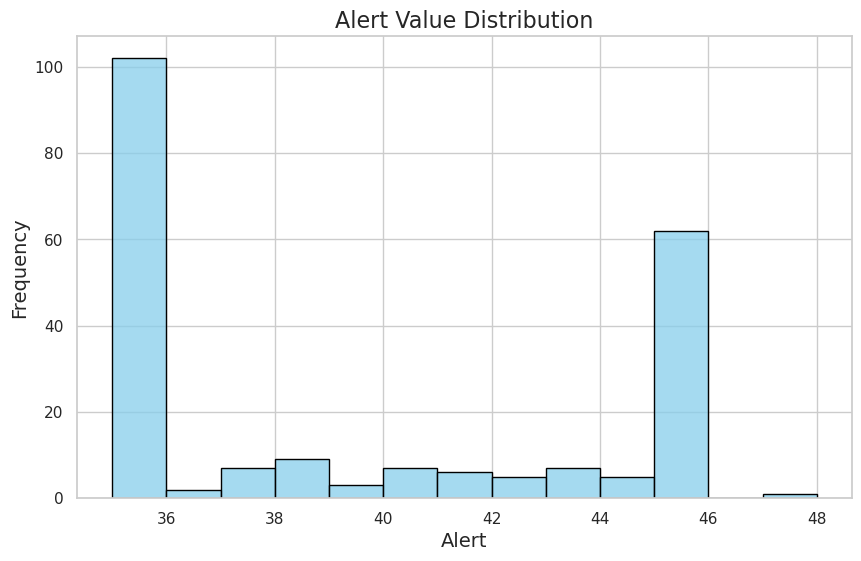

Alert Value is Bi-Modal


In [18]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.histplot(station_summary_snapshot['alert'].dropna(), 
             bins=(max(station_summary_snapshot['alert']) - min(station_summary_snapshot['alert'])), 
             kde=False, color='skyblue', edgecolor='black')

plt.title('Alert Value Distribution', fontsize=16)
plt.xlabel('Alert', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.show()
print('Alert Value is Bi-Modal')

/tmp/ipykernel_1185/70504552.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vri_counts.index, y=vri_counts.values, palette='viridis', order=['L', 'M', 'H'])


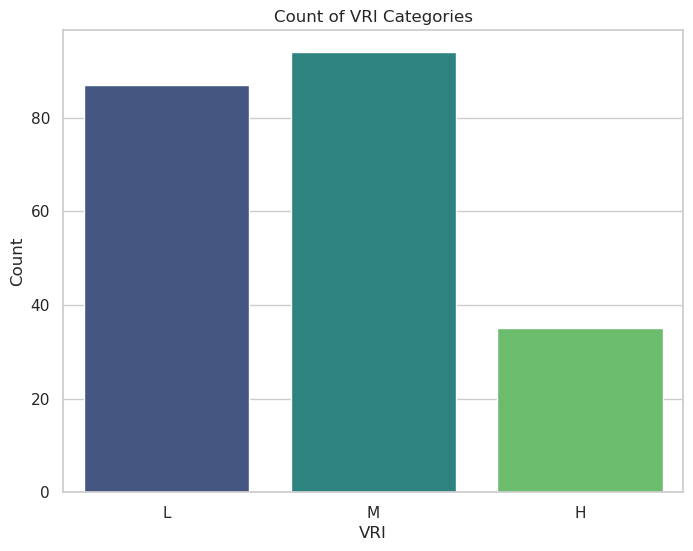

In [19]:
vri_counts = station_summary_snapshot['vri'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=vri_counts.index, y=vri_counts.values, palette='viridis', order=['L', 'M', 'H'])
plt.title('Count of VRI Categories')
plt.xlabel('VRI')
plt.ylabel('Count')
plt.show()

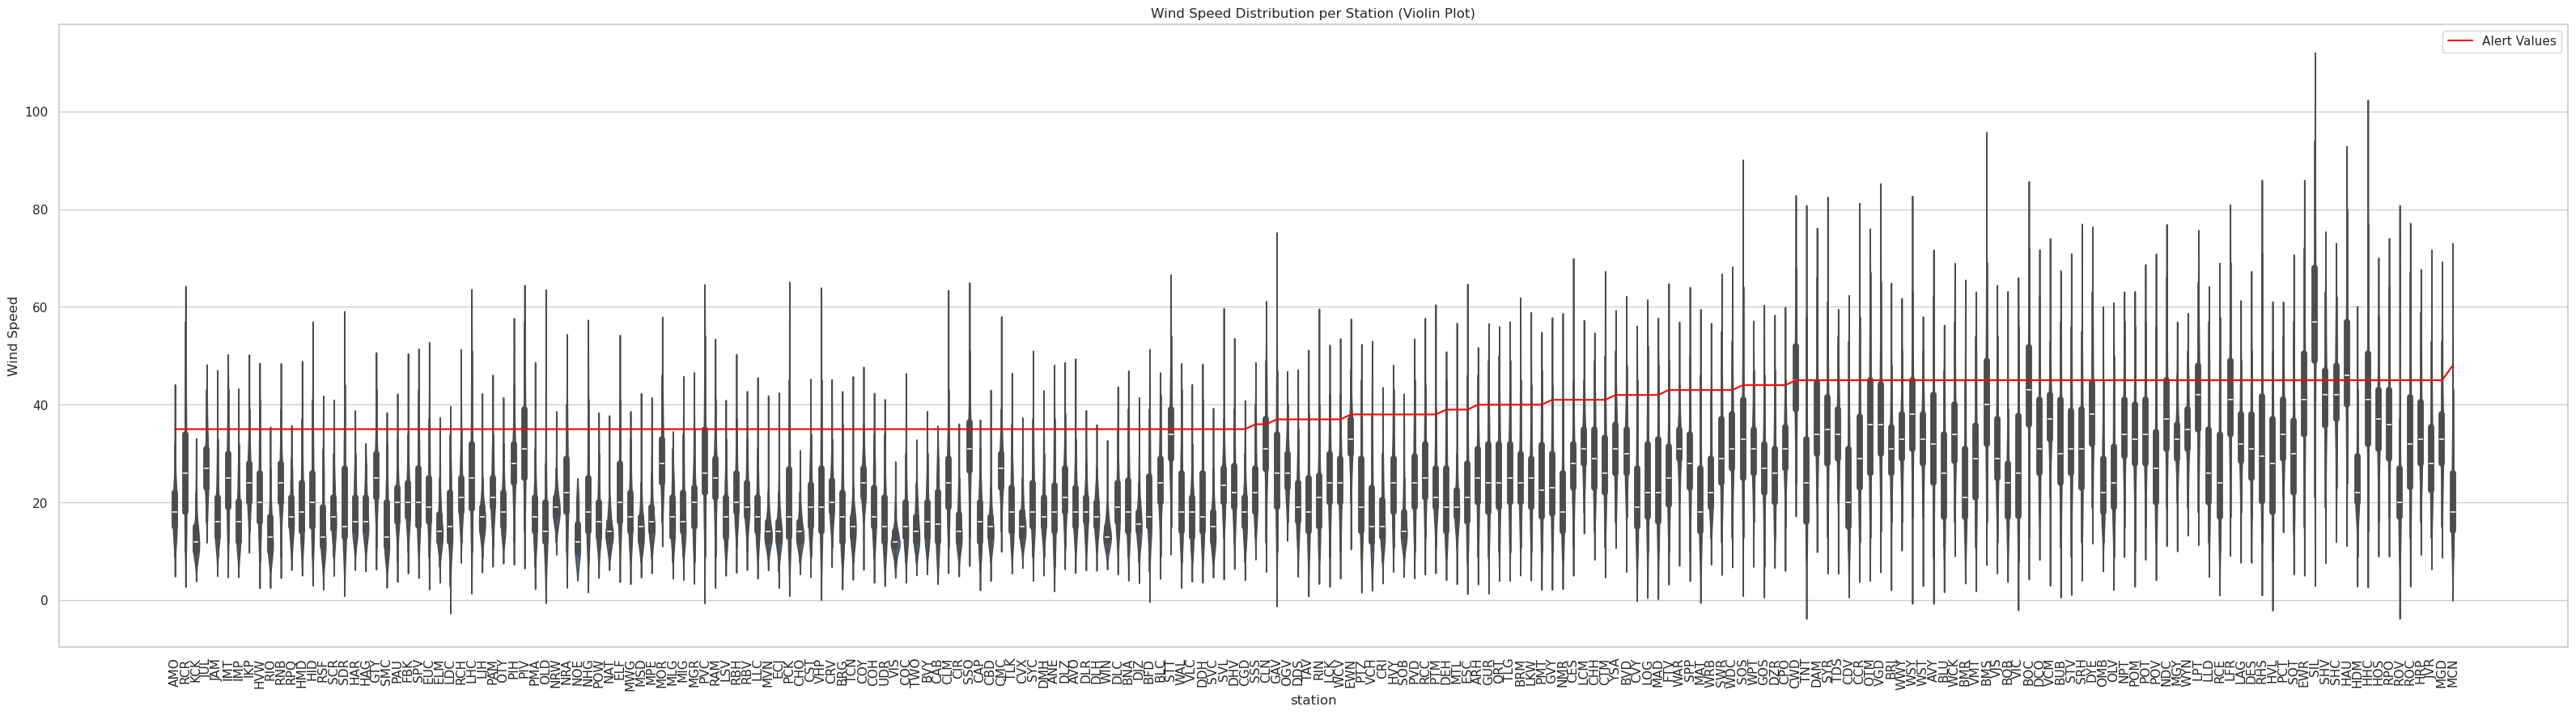

In [20]:
plt.figure(figsize=(40, 10))

#Sort station by ascending alert values
station_summary_sorted = station_summary_snapshot.sort_values(by='alert')
sorted_stations = station_summary_sorted['station'].values

# Set the x-axis order based on the sorted stations
sns.violinplot(x='station', y='wind_speed', data=windspeed_snapshot, order=sorted_stations)

# Plot the alert values
plt.plot(sorted_stations, station_summary_sorted['alert'].values, 
         marker='', color='red', label='Alert Values')

plt.xticks(rotation=90)
plt.ylabel('Wind Speed')
plt.title('Wind Speed Distribution per Station (Violin Plot)')
plt.legend()
plt.show()

In [21]:
merged_weather_station = gis_weather_station.merge(station_summary_snapshot, left_on='weatherstationcode', right_on='station').drop(columns=['station'])
merged_weather_station.head()

,objectid,weatherstationcode,weatherstationname,scadartuid,structureid,nwszone,district,thomasbrospagegrid,constructionstatus,creationuser,...,globalid,shape,shape_srid,snapshot_date_x,vri,alert,max_gust,99th,95th,snapshot_date_y
0,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,{ED5DE7F2-F63A-41EA-BA80-9F71495334A3},POINT (1540299.9388 12029375.0425),4431,10/4/2024,M,35,39,33,25,2023-08-02
1,2,CCR,Cuca Ranch,1915.0,Z118027,Mountain-258,3.0,1052-A5,A,seu_gis_elec,...,{82759049-437B-4A5C-8796-10C8D7098C5B},POINT (1667010.27856 12088881.1767),4431,10/4/2024,M,45,73,50,37,2023-08-02
2,3,CES,Country Estates,1995.0,Z416611,Inland Valley-250,3.0,1153-G7,A,seu_gis_elec,...,{6A3A6DAD-6CD1-43B7-A0FE-72A52A46A4F7},POINT (1703876.2967 11989778.75946),4431,10/4/2024,M,41,64,41,33,2023-08-02
3,208,ROV,Rim of the Valley,4818.0,Z416170,Inland Valley-250,3.0,1071-B1,A,gwharris,...,{AD1AEA81-BC74-4954-8D25-421C79F40D88},POINT (1646528.56915 12083236.45575),4431,10/4/2024,L,45,64,47,33,2023-08-02
4,5,CHO,Chollas Lake,5182.0,P970712,Inland Valley-250,1.0,1270-C7,A,seu_gis_elec,...,{1294A90A-9558-458E-8EA5-9D15B2A16D8D},POINT (1619955.10724 11883209.4286),4431,10/4/2024,L,35,30,25,19,2023-08-02


In [22]:
san_diego_map = folium.Map(location=[32.7157, -117.1611], zoom_start=10)

# Create a MarkerCluster object
marker_cluster = MarkerCluster().add_to(san_diego_map)

# Add markers to the map using the existing latitude and longitude columns
for _, row in merged_weather_station.iterrows():
    tooltip_text = f"""
    <strong>{row['weatherstationname']}</strong><br>
    Station Code: {row['weatherstationcode']}<br>
    VRI Value: {row['vri']}<br>
    Alert: {row['alert']}<br>
    """
    
    if row['vri'] == 'L':
        icon_color = 'lightred'
    elif row['vri'] == 'M':
        icon_color = 'orange'
    else:
        icon_color = 'red'
    
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        icon=folium.Icon(color=icon_color, icon="info-sign"),
        popup=tooltip_text,
        tooltip=tooltip_text
    ).add_to(marker_cluster)  # Add the marker to the MarkerCluster instead of the map

# Save the map
san_diego_map.save('san_diego_weather_stations_map.html')

# Display the map
IFrame('san_diego_weather_stations_map.html', width=800, height=500)

In [23]:
merged_station_wind_speed = merged_weather_station.merge(windspeed_snapshot, left_on='weatherstationcode', right_on='station').drop(columns=['station'])
merged_station_wind_speed.head()

,objectid,weatherstationcode,weatherstationname,scadartuid,structureid,nwszone,district,thomasbrospagegrid,constructionstatus,creationuser,...,snapshot_date_x,vri,alert,max_gust,99th,95th,snapshot_date_y,date,wind_speed,snapshot_date
0,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,10/4/2024,M,35,39,33,25,2023-08-02,12/10/2012,11.0,8/2/2023
1,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,10/4/2024,M,35,39,33,25,2023-08-02,12/19/2012,16.0,8/2/2023
2,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,10/4/2024,M,35,39,33,25,2023-08-02,12/20/2012,17.0,8/2/2023
3,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,10/4/2024,M,35,39,33,25,2023-08-02,12/25/2012,13.0,8/2/2023
4,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,10/4/2024,M,35,39,33,25,2023-08-02,4/18/2013,28.0,8/2/2023


<Figure size 1200x800 with 0 Axes>

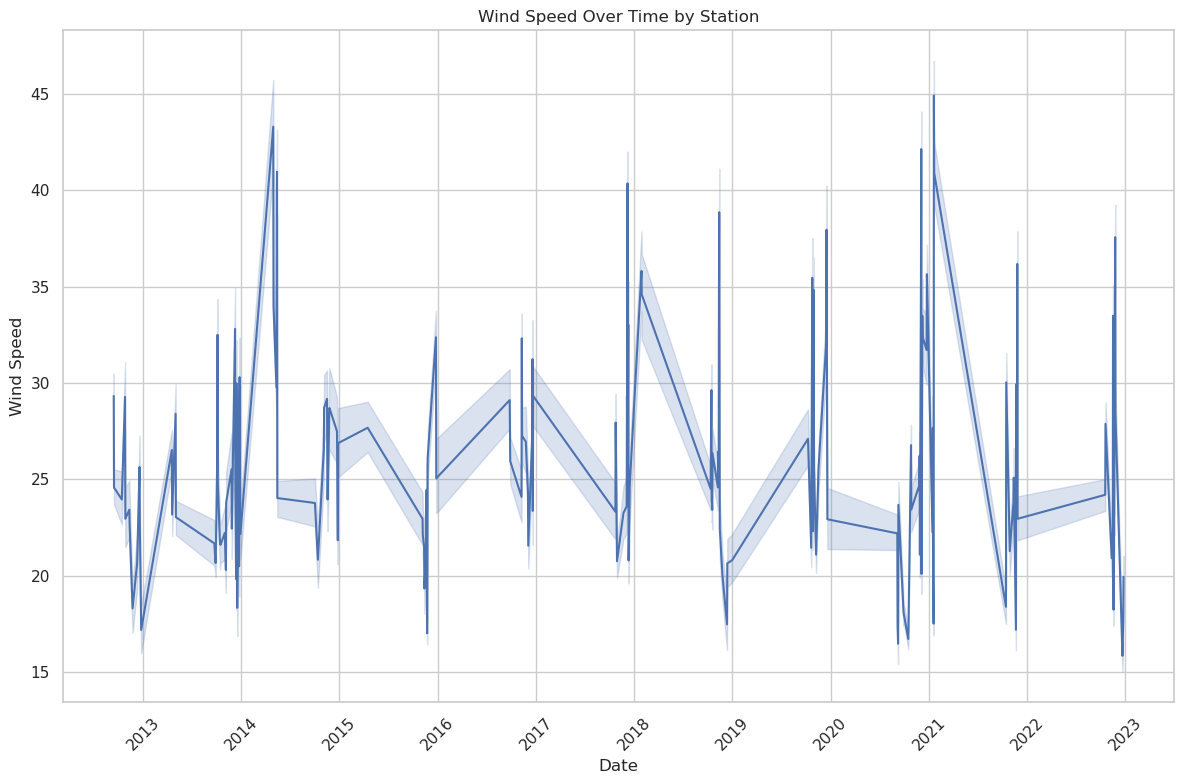

In [24]:
plt.figure(figsize=(12, 8))

merged_station_wind_speed['date'] = pd.to_datetime(merged_station_wind_speed['date'])

plt.figure(figsize=(12, 8))

# Plotting the wind speed over time
sns.lineplot(x='date', y='wind_speed', data=merged_station_wind_speed)

plt.title('Wind Speed Over Time by Station')
plt.xlabel('Date')
plt.ylabel('Wind Speed')
plt.xticks(rotation=45)

# Set x-axis major locator to year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Set minor locator to show ticks for each month
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())

# Show grid lines
plt.grid(visible=True)

# Show the plot
plt.tight_layout()
plt.show()

### Week 4

1) Calculating PSPS Probability for each Weather Station  
2) Visualizing Weather Station wind speed distributions against its wind speed threshold, and displaying its calculated PSPS Probability

In [25]:
merged_station_wind_speed.shape

(29762, 36)

In [26]:
wind_speed_count = merged_station_wind_speed.groupby('weatherstationcode')[['wind_speed']].count().rename(columns={'wind_speed':'wind_speed_count'})

windspeed_above_threshold = merged_station_wind_speed[merged_station_wind_speed['wind_speed'] > merged_station_wind_speed['alert']]
windspeed_count_above_threshold = windspeed_above_threshold.groupby('weatherstationcode')[['wind_speed']].count().rename(columns={'wind_speed':'above_threshold_count'})

combined_count = windspeed_count_above_threshold.merge(wind_speed_count, on="weatherstationcode", how='right')
combined_count['PSPS_probability'] = combined_count['above_threshold_count'] / combined_count['wind_speed_count']
combined_count

,above_threshold_count,wind_speed_count,PSPS_probability
weatherstationcode,,,
AMO,1.0,166,0.006024
ANE,3.0,179,0.016760
ARH,9.0,179,0.050279
AVO,4.0,179,0.022346
AVY,22.0,116,0.189655
...,...,...,...
WST,3.0,61,0.049180
WSY,43.0,176,0.244318
WWY,18.0,179,0.100559


In [27]:
weather_station_psps = gis_weather_station.merge(combined_count, left_on='weatherstationcode', right_index=True, how='left')
weather_station_psps['above_threshold_count'] = weather_station_psps['above_threshold_count'].fillna(0)
weather_station_psps['wind_speed_count'] = weather_station_psps['wind_speed_count'].fillna(0)
weather_station_psps['PSPS_probability'] = weather_station_psps['PSPS_probability'].fillna(0)
weather_station_psps

,objectid,weatherstationcode,weatherstationname,scadartuid,structureid,nwszone,district,thomasbrospagegrid,constructionstatus,creationuser,...,zone1idc,hftdidc,gdb_geomattr_data,globalid,shape,shape_srid,snapshot_date,above_threshold_count,wind_speed_count,PSPS_probability
0,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,N,N,NaN,{ED5DE7F2-F63A-41EA-BA80-9F71495334A3},POINT (1540299.9388 12029375.0425),4431,10/4/2024,2.0,171.0,0.011696
1,2,CCR,Cuca Ranch,1915.0,Z118027,Mountain-258,3.0,1052-A5,A,seu_gis_elec,...,N,Y,NaN,{82759049-437B-4A5C-8796-10C8D7098C5B},POINT (1667010.27856 12088881.1767),4431,10/4/2024,25.0,179.0,0.139665
2,3,CES,Country Estates,1995.0,Z416611,Inland Valley-250,3.0,1153-G7,A,seu_gis_elec,...,N,Y,NaN,{6A3A6DAD-6CD1-43B7-A0FE-72A52A46A4F7},POINT (1703876.2967 11989778.75946),4431,10/4/2024,10.0,173.0,0.057803
3,208,ROV,Rim of the Valley,4818.0,Z416170,Inland Valley-250,3.0,1071-B1,A,gwharris,...,N,Y,NaN,{AD1AEA81-BC74-4954-8D25-421C79F40D88},POINT (1646528.56915 12083236.45575),4431,10/4/2024,4.0,49.0,0.081633
4,5,CHO,Chollas Lake,5182.0,P970712,Inland Valley-250,1.0,1270-C7,A,seu_gis_elec,...,N,N,NaN,{1294A90A-9558-458E-8EA5-9D15B2A16D8D},POINT (1619955.10724 11883209.4286),4431,10/4/2024,0.0,117.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,146,HAU,Hauser Mountain,4828.0,Z972858,Mountain-258,4.0,1316-J1,A,calonzo,...,N,Y,NaN,{EFF383D5-266E-4B6D-A25B-C71D3B52247B},POINT (1776616.0495 11855234.4288),4431,10/4/2024,27.0,49.0,0.551020
219,223,BOB,Bob Owens Canyon,4841.0,Z571472,Inland Valley-250,4.0,1295-A7,A,CLCosby,...,N,Y,NaN,{9D545CF5-97C2-4EA1-A794-DEDCFD1D4437},POINT (1732301.64404 11860546.56055),4431,10/4/2024,4.0,45.0,0.088889
220,224,MWG,MT. WOODSON GOLF CLUB,4827.0,P518334,INLAND VALLEY-250,3.0,1171-D3,A,KSTETS,...,N,Y,NaN,{BCF2F0F6-C481-43A2-B237-DD05D83E0D13},POINT (1648988.038 11985389.44244),4431,10/4/2024,0.0,49.0,0.000000
221,4,CGD,Cole Grade,1957.0,Z416193,Inland Valley-250,3.0,1070-G1,A,seu_gis_elec,...,N,Y,NaN,{D0BC3059-6829-459B-AD6E-3446161600EF},POINT (1635642.92426 12082797.67706),4431,10/4/2024,1.0,179.0,0.005587


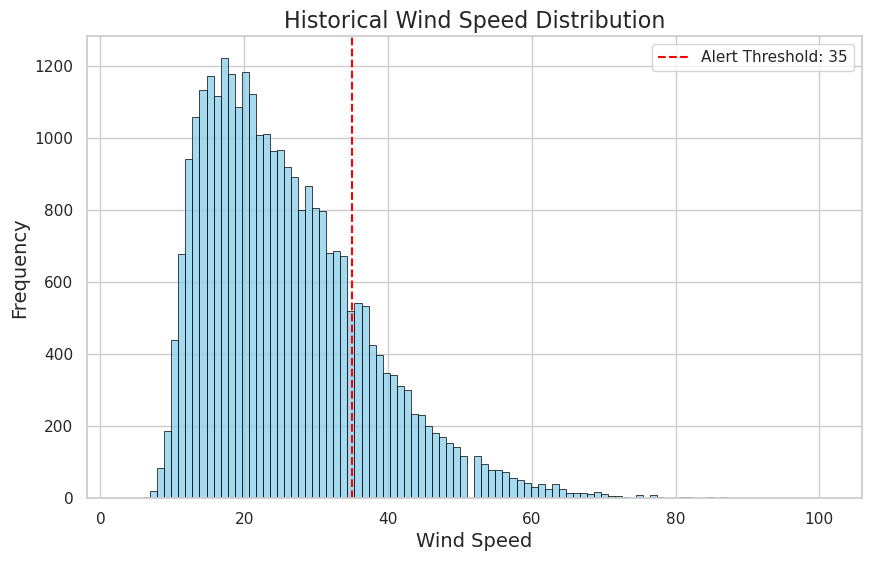

Wind Speed data is Right Skewed


In [28]:
alert_threshold = min(merged_station_wind_speed['alert'])

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.histplot(merged_station_wind_speed['wind_speed'].dropna(), bins=100, kde=False, color='skyblue', edgecolor='black')

plt.title('Historical Wind Speed Distribution', fontsize=16)
plt.xlabel('Wind Speed', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.axvline(x=alert_threshold, color='red', linestyle='--', label=f'Alert Threshold: {alert_threshold}')
plt.legend()

plt.show()
print('Wind Speed data is Right Skewed')

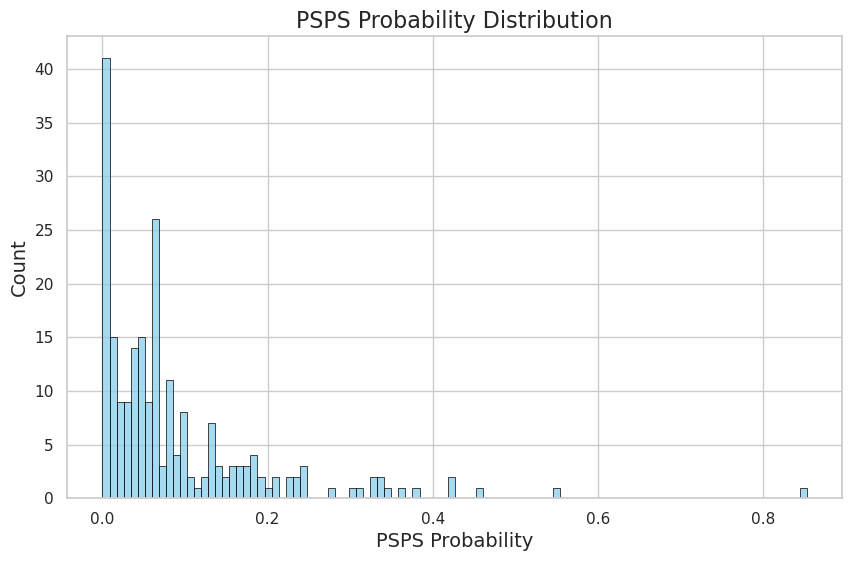

In [29]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.histplot(weather_station_psps['PSPS_probability'].dropna(), bins=100, kde=False, color='skyblue', edgecolor='black')

plt.title('PSPS Probability Distribution', fontsize=16)
plt.xlabel('PSPS Probability', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.show()

In [30]:
weather_station_psps[weather_station_psps['PSPS_probability'] > 0.80]

,objectid,weatherstationcode,weatherstationname,scadartuid,structureid,nwszone,district,thomasbrospagegrid,constructionstatus,creationuser,...,zone1idc,hftdidc,gdb_geomattr_data,globalid,shape,shape_srid,snapshot_date,above_threshold_count,wind_speed_count,PSPS_probability
12,13,SIL,Sill Hill,5164.0,P258571,Mountain-258,4.0,1195-G3,A,seu_gis_elec,...,N,Y,NaN,{613E692C-CF98-43EF-BB63-5F83E9E77004},POINT (1749936.5284 11962741.62946),4431,10/4/2024,151.0,177.0,0.853107


In [31]:
san_diego_map = folium.Map(location=[32.7157, -117.1611], zoom_start=10)

# Prepare data for the heatmap
heat_data = [[row['latitude'], row['longitude'], row['PSPS_probability']] for _, row in weather_station_psps.iterrows()]

# Add the heatmap with adjusted parameters
HeatMap(
    heat_data, 
    radius=15,         
    blur=10,           
    min_opacity=0,    
    gradient={0: 'blue', 0.5: 'lime', 1: 'red'}  
).add_to(san_diego_map)

# Save the map
san_diego_map.save('san_diego_weather_stations_map_with_heatmap.html')

# Display the map
IFrame('san_diego_weather_stations_map_with_heatmap.html', width=800, height=500)

#### Participation Week 4

In [32]:
weather_station_psps[weather_station_psps['wind_speed_count'] == 0]

,objectid,weatherstationcode,weatherstationname,scadartuid,structureid,nwszone,district,thomasbrospagegrid,constructionstatus,creationuser,...,zone1idc,hftdidc,gdb_geomattr_data,globalid,shape,shape_srid,snapshot_date,above_threshold_count,wind_speed_count,PSPS_probability
23,24,PSQC1,San Pasqual RAWS,19170.0,NaN,Inland Valley-250,3.0,1130-H7,A,seu_gis_elec,...,N,Y,NaN,{2AEDCEB8-308D-4209-BCEF-C8EF2CE1D022},POINT (1636678.4517 12012548.8901),4431,10/4/2024,0.0,0.0,0.0
26,27,PZAC1,Pala RAWS,19160.0,NaN,Inland Valley-250,3.0,1029-E5,A,seu_gis_elec,...,N,Y,NaN,{DD97A667-79C0-48B0-BF0B-49E123AA3A0F},POINT (1608030.63306 12110670.62823),4431,10/4/2024,0.0,0.0,0.0
83,84,TNSC1,Mountain Springs Grade RAWS,19180.0,NaN,Desert-232,NaN,NaN,A,seu_gis_elec,...,N,N,NaN,{F0BA7ADC-FF42-4D26-BADC-14F75C8AEF00},POINT (1918953.83795 11862248.423),4431,10/4/2024,0.0,0.0,0.0
97,98,BAJC1,Barrett RAWS,19090.0,Z105010,Inland Valley-250,4.0,1315-A1,A,seu_gis_elec,...,N,Y,NaN,{D6368869-868B-44DD-BEB7-76715F034612},POINT (1732857.3047 11858482.70184),4431,10/4/2024,0.0,0.0,0.0
115,117,ALLC1,Aliso Laguna RAWS,NaN,NaN,Coastal-552,NaN,951-B4,A,rfeura,...,N,N,NaN,{34DB73D6-40EC-409A-A0E6-C3814BA1A3CC},POINT (1410885.988 12174983.9287),4431,10/4/2024,0.0,0.0,0.0
133,135,BVDC1,MISSION VALLEY RAWS,19200.0,NaN,COASTAL-243,2.0,1269-D1,A,crfranco,...,N,N,NaN,{449FEDE4-48BB-4F62-BE60-E80720DB0A44},POINT (1598663.48285 11900349.9035),4431,10/4/2024,0.0,0.0,0.0


In [33]:
weather_station_psps[weather_station_psps['wind_speed_count'] > 0].sort_values(by=['wind_speed_count', 'PSPS_probability'], ascending=True)

,objectid,weatherstationcode,weatherstationname,scadartuid,structureid,nwszone,district,thomasbrospagegrid,constructionstatus,creationuser,...,zone1idc,hftdidc,gdb_geomattr_data,globalid,shape,shape_srid,snapshot_date,above_threshold_count,wind_speed_count,PSPS_probability
214,218,NOE,NORTH ESCONDIDO,4831.0,P315443,INLAND VALLEY-250,3.0,1109-J5,A,ad-AJRobert,...,N,N,NaN,{FABF7BE3-E655-4892-BAFA-249BA3FA6A04},POINT (1614939.2846 12035314.9702),4431,10/4/2024,0.0,14.0,0.000000
149,151,CAB,Caballo Park,4826.0,P314747,Inland Valley-250,3.0,1110-E4,A,jatamayo,...,N,Y,NaN,{60ED7DE9-6E6F-4ACB-835C-B99F0AB202B8},POINT (1630241.2799 12036771.8626),4431,10/4/2024,0.0,24.0,0.000000
157,211,DAM,MORENA DAM,4829.0,P42834,MOUNTAIN-258,4.0,1297-A5,A,asiman,...,N,Y,NaN,{9DC0EC85-1E2C-4D54-9006-E4AFBD88277B},POINT (1779985.3101 11865090.35004),4431,10/4/2024,10.0,43.0,0.232558
137,139,DLH,De Luz Heights,4838.0,Z322621,Inland Valley-250,3.0,997-C3,A,RPhilli1,...,N,Y,NaN,{D78BC63B-B994-4AF2-B94A-E89DA9E5856B},POINT (1554820.4465 12136181.48236),4431,10/4/2024,0.0,45.0,0.000000
219,223,BOB,Bob Owens Canyon,4841.0,Z571472,Inland Valley-250,4.0,1295-A7,A,CLCosby,...,N,Y,NaN,{9D545CF5-97C2-4EA1-A794-DEDCFD1D4437},POINT (1732301.64404 11860546.56055),4431,10/4/2024,4.0,45.0,0.088889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,29,DYE,Dye Mountain,5163.0,Z416663,Inland Valley-250,3.0,1154-G1,A,seu_gis_elec,...,N,Y,NaN,{84E04612-A6E6-4F34-B31E-3A752D68075E},POINT (1729251.57825 12004425.594),4431,10/4/2024,43.0,179.0,0.240223
78,79,SSO,Sunset Oaks,1903.0,P161775,Inland Valley-250,3.0,1153-D1,A,seu_gis_elec,...,N,Y,NaN,{85492C07-A335-4277-B4FC-C7A9B846E875},POINT (1697437.6216 12006428.5221),4431,10/4/2024,54.0,179.0,0.301676
70,71,BMS,Buckman Springs,1911.0,Z40527,Mountain-258,4.0,1277,A,seu_gis_elec,...,N,Y,NaN,{6B90B898-DD14-46F9-A4ED-F7E06F558AC4},POINT (1797548.50006 11893036.2482),4431,10/4/2024,61.0,179.0,0.340782
170,173,LPT,La Posta,5121.0,P40815,Mountain-258,4.0,1278,A,seu_gis_elec,...,N,Y,NaN,{A441C235-6825-4152-9E07-27BF13CD1D5A},POINT (1823240.5527 11875046.1372),4431,10/4/2024,61.0,179.0,0.340782


In [34]:
wind_speed_count.shape

(215, 1)

### Week 5
Description:  
    Merging weather station data to conductor spans and displaying PSPS Probabilities across all 3 layers geospatially  
  
1) Merge weather stations to VRI polygons  
2) Merge VRI polgyons to Conductor Spans  
3) Displaying PSPS Probabilities across all 3 layers geospatially

In [35]:
# Read new data
dev_wings_agg_span = pd.read_csv('./data/dev_wings_agg_span_2024_01_01.csv', low_memory=False).drop(columns=['Unnamed: 0'])
src_vri_snapshot = pd.read_csv('./data/src_vri_snapshot_2024_03_20.csv')

In [36]:
dev_wings_agg_span.head()

,globalid,ohug,feederid,upstreamardfacilityid,is_span,upstream_struct_id,upstream_struct_age,upstream_struct_material,upstream_struct_hftd,upstream_struct_type,...,exclusive_tree_ids,exclusive_tree_counts,transformer_counts,model_major_ver,model_minor_ver,model_patch_ver,snapshot_date,upstream_span_id,shape,shape_srid
0,{D43C3C53-4663-4CA4-98AF-935B4ED9A1CB},UG,287,287-1118,True,H120382,20.750000,CON,NaN,ug,...,NaN,NaN,NaN,3.0,158.0,0.0,2024-01-01,{23877069-F148-45BA-9EB8-CBE1DF9A6D87},"LINESTRING (6262824.385223 1966604.00775, 6262...",2230
1,{789A64FB-CAED-4655-A1A9-6A46FE173EFA},UG,592,CB 592,True,D158469,19.166667,CON,NaN,surf,...,NaN,NaN,NaN,3.0,158.0,0.0,2024-01-01,{D1DA2634-B16A-4832-A6C7-9D10F30321E0},"LINESTRING (6337848.418706 1824432.373038, 633...",2230
2,{AF0DB072-C612-4C23-80B6-8C731F9DE067},UG,515,CB 515,True,P419949,52.000000,WOOD,1.0,oh,...,NaN,NaN,NaN,3.0,158.0,0.0,2024-01-01,{3ACC0522-7F97-4EB8-B5FC-DF7BB0E86FDC},"LINESTRING (6302190.878315 1988000.130156, 630...",2230
3,{9075BD1C-B63A-4F89-8628-967390472DF7},UG,206,CB 206,True,D3757069965,11.750000,CON,NaN,surf,...,NaN,NaN,NaN,3.0,158.0,0.0,2024-01-01,{BBD75672-0758-4D28-AA67-375118575D37},"LINESTRING (6261002.674284 2016121.134633, 626...",2230
4,{29C69D0D-5C72-4310-8C49-99E92F0FAA4A},UG,907,907-1602,True,D170472,13.750000,CON,NaN,surf,...,NaN,NaN,NaN,3.0,158.0,0.0,2024-01-01,{6B21F305-DA24-4D01-B3AA-8738862C91E3},"LINESTRING (6325069.828199 2028673.724143, 632...",2230


In [37]:
src_vri_snapshot.head()

,name,tessellate,extrude,visibility,globalid,anemometer,anemometercode,circuit,district,secdevice,...,county,hftd,hftdidc,zone1idc,globalid_1,shape_length,shape_area,shape,shape_srid,snapshot_date
0,Alpine_VRI,-1,0,-1,{9301dece-bb90-40f2-a2b3-97ddb7e2da50},Alpine_VRI,ANE,NaN,EA,NaN,...,SAN DIEGO,Tier 2,Y,N,{A0A86957-55F4-4FE3-A668-90BC2E37B24E},16546.607726,6.250091e+06,"MULTIPOLYGON Z (((-116.783579 32.826647 0, -11...",4326,2024-03-20
1,Ammo Dump_VRI,-1,0,-1,{c0955e19-d2f7-49f5-80ce-d0c46bc76e79},Ammo Dump_VRI,AMO,NaN,NC,NaN,...,SAN DIEGO,Tier 2,Y,N,{3879A192-5CDC-47B6-BF30-8F2B20E9CD3A},67396.343292,8.471005e+07,"MULTIPOLYGON Z (((-117.297615 33.325552 0, -11...",4326,2024-03-20
2,Anderson Valley_VRI,-1,0,-1,{8fd4f643-514c-4b53-ad51-a9ac54abcbb3},Anderson Valley_VRI,AVY,NaN,EA,NaN,...,SAN DIEGO,Tier 3,Y,N,{17F90E02-1078-47C6-90DD-18136A76B374},7441.466609,1.767049e+06,"MULTIPOLYGON Z (((-116.753684 32.879331 0, -11...",4326,2024-03-20
3,Archie Moore_VRI,-1,0,-1,{e2879aaa-fc7a-455e-af56-382a253d08f0},Archie Moore_VRI,ARH,NaN,NE,NaN,...,SAN DIEGO,Tier 3,Y,N,{F2C2B664-8804-4996-B4B5-143AA74B75FD},11686.591562,8.474172e+06,"MULTIPOLYGON Z (((-116.988931 33.050367 0, -11...",4326,2024-03-20
4,Avocado_VRI,-1,0,-1,{ef385198-487b-483e-83c4-ee9496ac29d6},Avocado_VRI,AVO,NaN,NE,NaN,...,SAN DIEGO;RIVERSIDE,Tier 2,Y,N,{38C385CA-3F46-4A34-87F3-8E42DAB14F60},33397.539225,3.757193e+07,"MULTIPOLYGON Z (((-117.214118 33.377714 0, -11...",4326,2024-03-20


In [38]:
src_vri_snapshot.isna().sum()

name                0
tessellate          0
extrude             0
visibility          0
globalid           81
anemometer          0
anemometercode    100
circuit           301
district           38
secdevice         301
structureid       107
tlid              206
gust_99pct         73
gust_95pct         73
gust_max           73
vri_risk            1
loaddate           81
county             79
hftd                0
hftdidc             0
zone1idc            0
globalid_1          0
shape_length        0
shape_area          0
shape               0
shape_srid          0
snapshot_date       0
dtype: int64

In [39]:
print("Shape of dev_wings_agg_span:", dev_wings_agg_span.shape)
print("Shape of src_vri_snapshot:", src_vri_snapshot.shape)

Shape of dev_wings_agg_span: (674592, 103)
Shape of src_vri_snapshot: (308, 27)


#### 1) Merge weather stations to VRI polygons

In [40]:
weather_station_psps['geometry'] = weather_station_psps['shape'].apply(wkt.loads)
weather_station_psps_gpd = gpd.GeoDataFrame(weather_station_psps, geometry='geometry', crs=f"EPSG:{weather_station_psps['shape_srid'][0]}")

src_vri_snapshot['geometry'] = src_vri_snapshot['shape'].apply(wkt.loads)
src_vri_snapshot_gpd = gpd.GeoDataFrame(src_vri_snapshot, geometry='geometry', crs=f"EPSG:{src_vri_snapshot['shape_srid'][0]}")

# Ensure both GeoDataFrames have the same CRS
weather_station_psps_gpd = weather_station_psps_gpd.to_crs(src_vri_snapshot_gpd.crs)

# Perform the spatial join to find weather stations within each VRI polygon
merged_station_vri_gpd = gpd.sjoin(weather_station_psps_gpd, src_vri_snapshot_gpd, predicate="within", how="inner")

# Display the resulting joined GeoDataFrame
merged_station_vri_gpd.head()

,objectid,weatherstationcode,weatherstationname,scadartuid,structureid_left,nwszone,district_left,thomasbrospagegrid,constructionstatus,creationuser,...,county,hftd_right,hftdidc_right,zone1idc_right,globalid_1,shape_length,shape_area,shape_right,shape_srid_right,snapshot_date_right
0,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,SAN DIEGO,Non-HFTD,N,N,{C20D60A1-F6E8-4FD3-AF1F-C54B1A26E6DA},38417.323143,2.768495e+07,"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",4326,2024-03-20
0,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,NaN,Non-HFTD,N,N,{06AB2161-9C7E-46A2-B25F-CDEC5983D2F2},80438.177003,9.097170e+06,"MULTIPOLYGON Z (((-117.334398 33.212038 0, -11...",4326,2024-03-20
1,2,CCR,Cuca Ranch,1915.0,Z118027,Mountain-258,3.0,1052-A5,A,seu_gis_elec,...,SAN DIEGO,Tier 3,Y,N,{425B9034-E2AF-4A09-927E-3C2FC602F282},19938.846484,9.575396e+06,"MULTIPOLYGON Z (((-116.937336 33.301243 0, -11...",4326,2024-03-20
1,2,CCR,Cuca Ranch,1915.0,Z118027,Mountain-258,3.0,1052-A5,A,seu_gis_elec,...,SAN DIEGO,Both,Y,Y,{A606BE3B-1A61-400F-B37C-DB21727742CA},78533.414786,8.578501e+06,"MULTIPOLYGON Z (((-116.819199 33.266861 0, -11...",4326,2024-03-20
2,3,CES,Country Estates,1995.0,Z416611,Inland Valley-250,3.0,1153-G7,A,seu_gis_elec,...,SAN DIEGO,Tier 3,Y,N,{2F678369-E70E-4910-81F3-13694AB6283C},26301.367177,2.313316e+07,"MULTIPOLYGON Z (((-116.829876 33.055708 0, -11...",4326,2024-03-20


In [41]:
print(weather_station_psps_gpd.crs)
print(src_vri_snapshot_gpd.crs)

EPSG:4326
EPSG:4326


In [42]:
merged_station_vri_gpd.shape

(307, 59)

#### 2) Merge VRI polgyons to Conductor Spans

In [43]:
dev_wings_agg_span['geometry'] = dev_wings_agg_span['shape'].apply(wkt.loads)
dev_wings_agg_span_gpd = gpd.GeoDataFrame(dev_wings_agg_span, geometry='geometry', crs=f"EPSG:{dev_wings_agg_span['shape_srid'][0]}")
dev_wings_agg_span_gpd = dev_wings_agg_span_gpd.to_crs(merged_station_vri_gpd.crs)

merged_station_vri_spans_gpd = merged_station_vri_gpd.merge(dev_wings_agg_span_gpd, left_on="weatherstationcode", right_on="station", how='inner')
merged_station_vri_spans_gpd.head()

,objectid,weatherstationcode,weatherstationname,scadartuid,structureid_left,nwszone,district_left,thomasbrospagegrid,constructionstatus,creationuser,...,exclusive_tree_counts,transformer_counts,model_major_ver,model_minor_ver,model_patch_ver,snapshot_date,upstream_span_id,shape,shape_srid,geometry_y
0,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,NaN,NaN,3.0,158.0,0.0,2024-01-01,{290A717F-C209-47EE-83C1-57E082732C56},"LINESTRING (6248655.573299 1994627.359204, 624...",2230,"LINESTRING (-117.27252 33.13595, -117.27253 33..."
1,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,NaN,NaN,3.0,158.0,0.0,2024-01-01,{C3C9EC8C-FA86-409B-BB21-39251C3362D0},"LINESTRING (6247093.343545 1988997.505982, 624...",2230,"LINESTRING (-117.27745 33.12044, -117.27747 33..."
2,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,NaN,NaN,3.0,158.0,0.0,2024-01-01,{C89051A3-68E8-41D4-80F2-40F3F8A8BD2B},"LINESTRING (6221680.58643 2021384.953729, 6221...",2230,"LINESTRING (-117.36157 33.20873, -117.36157 33..."
3,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,NaN,NaN,3.0,158.0,0.0,2024-01-01,{900E2ACE-689F-4962-8A2E-571632650D56},"LINESTRING (6250043.937519 1969545.021235, 625...",2230,"LINESTRING (-117.26719 33.06706, -117.26718 33..."
4,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,NaN,NaN,3.0,158.0,0.0,2024-01-01,{C5EDC30D-D2E9-47E4-9983-87F7A7FCD6B5},"LINESTRING (6243233.636976 1975575.367498, 624...",2230,"LINESTRING (-117.28961 33.08344, -117.28961 33..."


In [44]:
merged_station_vri_spans_gpd.shape

(526054, 163)

In [45]:
print(dev_wings_agg_span_gpd.crs)
print(merged_station_vri_gpd.crs)

print(dev_wings_agg_span_gpd.is_valid.all())  # Should return True
print(merged_station_vri_gpd.is_valid.all())    # Should return True


EPSG:4326
EPSG:4326
True
True


#### 3) Displaying PSPS Probabilities across all 3 layers geospatially

In [46]:
weather_station_psps_gpd.head()

,objectid,weatherstationcode,weatherstationname,scadartuid,structureid,nwszone,district,thomasbrospagegrid,constructionstatus,creationuser,...,hftdidc,gdb_geomattr_data,globalid,shape,shape_srid,snapshot_date,above_threshold_count,wind_speed_count,PSPS_probability,geometry
0,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,N,NaN,{ED5DE7F2-F63A-41EA-BA80-9F71495334A3},POINT (1540299.9388 12029375.0425),4431,10/4/2024,2.0,171.0,0.011696,POINT (-117.32717 33.13735)
1,2,CCR,Cuca Ranch,1915.0,Z118027,Mountain-258,3.0,1052-A5,A,seu_gis_elec,...,Y,NaN,{82759049-437B-4A5C-8796-10C8D7098C5B},POINT (1667010.27856 12088881.1767),4431,10/4/2024,25.0,179.0,0.139665,POINT (-116.91293 33.30135)
2,3,CES,Country Estates,1995.0,Z416611,Inland Valley-250,3.0,1153-G7,A,seu_gis_elec,...,Y,NaN,{6A3A6DAD-6CD1-43B7-A0FE-72A52A46A4F7},POINT (1703876.2967 11989778.75946),4431,10/4/2024,10.0,173.0,0.057803,POINT (-116.79287 33.02874)
3,208,ROV,Rim of the Valley,4818.0,Z416170,Inland Valley-250,3.0,1071-B1,A,gwharris,...,Y,NaN,{AD1AEA81-BC74-4954-8D25-421C79F40D88},POINT (1646528.56915 12083236.45575),4431,10/4/2024,4.0,49.0,0.081633,POINT (-116.97999 33.28586)
4,5,CHO,Chollas Lake,5182.0,P970712,Inland Valley-250,1.0,1270-C7,A,seu_gis_elec,...,N,NaN,{1294A90A-9558-458E-8EA5-9D15B2A16D8D},POINT (1619955.10724 11883209.4286),4431,10/4/2024,0.0,117.0,0.000000,POINT (-117.06657 32.73588)


In [47]:
src_vri_snapshot_gpd.head()

,name,tessellate,extrude,visibility,globalid,anemometer,anemometercode,circuit,district,secdevice,...,hftd,hftdidc,zone1idc,globalid_1,shape_length,shape_area,shape,shape_srid,snapshot_date,geometry
0,Alpine_VRI,-1,0,-1,{9301dece-bb90-40f2-a2b3-97ddb7e2da50},Alpine_VRI,ANE,NaN,EA,NaN,...,Tier 2,Y,N,{A0A86957-55F4-4FE3-A668-90BC2E37B24E},16546.607726,6.250091e+06,"MULTIPOLYGON Z (((-116.783579 32.826647 0, -11...",4326,2024-03-20,"MULTIPOLYGON Z (((-116.78358 32.82665 0, -116...."
1,Ammo Dump_VRI,-1,0,-1,{c0955e19-d2f7-49f5-80ce-d0c46bc76e79},Ammo Dump_VRI,AMO,NaN,NC,NaN,...,Tier 2,Y,N,{3879A192-5CDC-47B6-BF30-8F2B20E9CD3A},67396.343292,8.471005e+07,"MULTIPOLYGON Z (((-117.297615 33.325552 0, -11...",4326,2024-03-20,"MULTIPOLYGON Z (((-117.29762 33.32555 0, -117...."
2,Anderson Valley_VRI,-1,0,-1,{8fd4f643-514c-4b53-ad51-a9ac54abcbb3},Anderson Valley_VRI,AVY,NaN,EA,NaN,...,Tier 3,Y,N,{17F90E02-1078-47C6-90DD-18136A76B374},7441.466609,1.767049e+06,"MULTIPOLYGON Z (((-116.753684 32.879331 0, -11...",4326,2024-03-20,"MULTIPOLYGON Z (((-116.75368 32.87933 0, -116...."
3,Archie Moore_VRI,-1,0,-1,{e2879aaa-fc7a-455e-af56-382a253d08f0},Archie Moore_VRI,ARH,NaN,NE,NaN,...,Tier 3,Y,N,{F2C2B664-8804-4996-B4B5-143AA74B75FD},11686.591562,8.474172e+06,"MULTIPOLYGON Z (((-116.988931 33.050367 0, -11...",4326,2024-03-20,"MULTIPOLYGON Z (((-116.98893 33.05037 0, -116...."
4,Avocado_VRI,-1,0,-1,{ef385198-487b-483e-83c4-ee9496ac29d6},Avocado_VRI,AVO,NaN,NE,NaN,...,Tier 2,Y,N,{38C385CA-3F46-4A34-87F3-8E42DAB14F60},33397.539225,3.757193e+07,"MULTIPOLYGON Z (((-117.214118 33.377714 0, -11...",4326,2024-03-20,"MULTIPOLYGON Z (((-117.21412 33.37771 0, -117...."


In [48]:
dev_wings_agg_span_gpd.head()

,globalid,ohug,feederid,upstreamardfacilityid,is_span,upstream_struct_id,upstream_struct_age,upstream_struct_material,upstream_struct_hftd,upstream_struct_type,...,exclusive_tree_counts,transformer_counts,model_major_ver,model_minor_ver,model_patch_ver,snapshot_date,upstream_span_id,shape,shape_srid,geometry
0,{D43C3C53-4663-4CA4-98AF-935B4ED9A1CB},UG,287,287-1118,True,H120382,20.750000,CON,NaN,ug,...,NaN,NaN,3.0,158.0,0.0,2024-01-01,{23877069-F148-45BA-9EB8-CBE1DF9A6D87},"LINESTRING (6262824.385223 1966604.00775, 6262...",2230,"LINESTRING (-117.22538 33.05931, -117.22539 33..."
1,{789A64FB-CAED-4655-A1A9-6A46FE173EFA},UG,592,CB 592,True,D158469,19.166667,CON,NaN,surf,...,NaN,NaN,3.0,158.0,0.0,2024-01-01,{D1DA2634-B16A-4832-A6C7-9D10F30321E0},"LINESTRING (6337848.418706 1824432.373038, 633...",2230,"LINESTRING (-116.97729 32.67026, -116.97731 32..."
2,{AF0DB072-C612-4C23-80B6-8C731F9DE067},UG,515,CB 515,True,P419949,52.000000,WOOD,1.0,oh,...,NaN,NaN,3.0,158.0,0.0,2024-01-01,{3ACC0522-7F97-4EB8-B5FC-DF7BB0E86FDC},"LINESTRING (6302190.878315 1988000.130156, 630...",2230,"LINESTRING (-117.09747 33.11906, -117.09751 33..."
3,{9075BD1C-B63A-4F89-8628-967390472DF7},UG,206,CB 206,True,D3757069965,11.750000,CON,NaN,surf,...,NaN,NaN,3.0,158.0,0.0,2024-01-01,{BBD75672-0758-4D28-AA67-375118575D37},"LINESTRING (6261002.674284 2016121.134633, 626...",2230,"LINESTRING (-117.23285 33.19535, -117.23285 33..."
4,{29C69D0D-5C72-4310-8C49-99E92F0FAA4A},UG,907,907-1602,True,D170472,13.750000,CON,NaN,surf,...,NaN,NaN,3.0,158.0,0.0,2024-01-01,{6B21F305-DA24-4D01-B3AA-8738862C91E3},"LINESTRING (6325069.828199 2028673.724143, 632...",2230,"LINESTRING (-117.02373 33.23133, -117.02369 33..."


In [49]:
# Save as GeoJson
dev_wings_agg_span_simplified = dev_wings_agg_span_gpd.simplify(tolerance=1000)
dev_wings_agg_span_simplified.line_merge(directed=True)
dev_wings_agg_span_simplified.to_file("simplified_dev_wings_agg_span.geojson", driver="GeoJSON")

In [50]:
# Initialize the map
m = folium.Map(location=[32.7157, -117.1611], zoom_start=10, tiles="OpenStreetMap")

# Weather Station
weather_stations = folium.FeatureGroup(name='Weather Stations')
marker_cluster = MarkerCluster().add_to(weather_stations)

for idx, row in weather_station_psps_gpd.iterrows():
    folium.CircleMarker(
        location=(row["latitude"], row["longitude"]),
        radius=4,
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.2,
        tooltip=(f"Station: {row['weatherstationname']}<br>"
                 f"PSPS Probability: {row['PSPS_probability']:.3f}")
    ).add_to(marker_cluster)

# VRI Snapshot
vri_snapshot = folium.FeatureGroup(name='VRI Snapshot')

# Load simplified GeoJSON with tooltip
vri_tooltip = folium.GeoJsonTooltip(
    fields=["name", "vri_risk", "shape_area"],
    aliases=["Name:", "VRI Risk:", "Shape Area:"],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """,
    max_width=800,
)

# Load VRI GeoJSON
vri_map = folium.GeoJson(
    src_vri_snapshot_gpd,
    style_function=lambda x: {
        "fillColor": "orange",
        "color": "black",
        "weight": 0.3,
        "fillOpacity": 0.5
    },
    tooltip=vri_tooltip,
)
vri_map.add_to(vri_snapshot)

# Spans
spans = folium.FeatureGroup(name='Spans')

# Load Spans GeoJSON
span_map = folium.GeoJson(
    "simplified_dev_wings_agg_span.geojson",
    style_function=lambda x: {
        "fillColor": "green",
        "color": "green",
        "weight": 0.3,
        "fillOpacity": 0.5
    },
)
span_map.add_to(spans)

# Add feature groups to the map
vri_snapshot.add_to(m)
spans.add_to(m)

# Add layer control to toggle feature groups
folium.LayerControl().add_to(m)

# Save the map
m.save("san_diego_weather_stations_map_vri_span.html")

In [51]:
# Display the map
# IFrame("san_diego_weather_stations_map_vri_span.html", width="200px", height="100px") # Uncomment, but currently cannot load

### Participation Week 5


1) Any anomalies or edge cases you encountered during the spatial join process? If so, how did you deal with them?  
2) Any computation roadblocks with the spatial joining or geospatial map creation process ? If so, how did overcome them?  
3) Anything else interesting or challenging you encountered during the process or from looking at the results? Any ideas come to mind that maybe weren't part of the task at hand yet could be of interest for future project milestones?  

### Week 6

1) Creating a networkX graph object of the conductor span data and enabling upstream/downstream tracing from any span  
2) Performing span tracing to determine all weather station associations to a given span whereby the weather station reaching its shut-off alert speed would cause the span to be shut-off 

In [52]:
import networkx as nx
import matplotlib.pyplot as plt
import math

In [53]:
a = ""
for row in merged_station_vri_spans_gpd.head(1).itertuples(index=True, name='Pandas'):
    a = row

for column in a._fields:
    data = getattr(a, column)
    print(f"{column}: {data}")


Index: 0
objectid: 1
weatherstationcode: CBD
weatherstationname: Carlsbad
scadartuid: 5158.0
structureid_left: P124785
nwszone: Coastal-243
district_left: 6.0
thomasbrospagegrid: 1126-G1
constructionstatus: A
creationuser: seu_gis_elec
datecreated: 00:00.0
datemodified: 00:00.0
lastuser: bsingh
structureguid: {64494E39-29E5-4911-ACB1-32A8CB6BCF2D}
symbolrotation: 0
latitude: 33.137352
longitude: -117.327141
elevation: 72
twinguid: nan
hftd_left: 1
zone1idc_left: N
hftdidc_left: N
gdb_geomattr_data: nan
globalid_left: {ED5DE7F2-F63A-41EA-BA80-9F71495334A3}
shape_left: POINT (1540299.9388 12029375.0425)
shape_srid_left: 4431
snapshot_date_left: 10/4/2024
above_threshold_count: 2.0
wind_speed_count: 171.0
PSPS_probability: 0.011695906432748537
geometry_x: POINT (-117.32717167443597 33.137345245820136)
index_right: 24
name: Carlsbad_VRI
tessellate: -1
extrude: 0
visibility: -1
globalid_right: {a5506318-6dfa-4de3-9df0-17deac78ed06}
anemometer: Carlsbad_VRI
anemometercode: CBD
circuit: nan
d

In [54]:
start_node = dev_wings_agg_span.iloc[234234]['globalid']
start_node

'{E4DA3C3C-6342-4BA0-9745-928BF2EB1E58}'

In [55]:
G = nx.DiGraph()
span_weather_station = dict()

for row in merged_station_vri_spans_gpd.itertuples(index=True, name='Pandas'):
    G.add_edge(row.globalid, row.upstream_span_id)
    span_weather_station[row.globalid] = (row.weatherstationcode, row.PSPS_probability)

#DFS
dfs_downstream = nx.dfs_predecessors(G, start_node)
dfs_upstream = nx.dfs_successors(G, start_node)

#BFS
bfs_downstream = dict(nx.bfs_predecessors(G, start_node))
bfs_upstream = dict(nx.bfs_successors(G, start_node))

In [56]:
merged_station_vri_spans_gpd.shape

(526054, 163)

In [57]:
def getUpstream(G, start_node, algorithm):
    tracing = dict()
    if algorithm.lower() == 'bfs':
        tracing = dict(nx.bfs_successors(G, start_node))
    elif algorithm.lower() == 'dfs':
        tracing = nx.dfs_successors(G, start_node)
    else:
        print('Invalid Algorithm')
        return

    upstream_nodes = [node[0] for node in tracing.values() if not (isinstance(node[0], float) and math.isnan(node[0]))]
    return upstream_nodes

def getDownstream(G, start_node, algorithm):
    tracing = dict()
    if algorithm.lower() == 'bfs':
        tracing = dict(nx.bfs_predecessors(G, start_node))
    elif algorithm.lower() == 'dfs':
        tracing = nx.dfs_predecessors(G, start_node)
    else:
        print('Invalid Algorithm')
        return

    downstream_nodes = [node for node in tracing.keys() if not (isinstance(node, float) and math.isnan(node))]
    return downstream_nodes

associated_weather_station_to_span = dict()

for row in merged_station_vri_spans_gpd.itertuples(index=True, name='Pandas'):
    upstream_spans = getUpstream(G, row.globalid, 'dfs') + [row.globalid]

    weather_stations = set([span_weather_station[span] for span in upstream_spans if span in span_weather_station])
    associated_weather_station_to_span[row.globalid] = weather_stations

In [58]:
print(associated_weather_station_to_span[start_node])

{('TCN', 0.01694915254237288), ('MSD', 0.0111731843575419)}


### Participation Week 6

1) Any anomalies or edge cases you encountered while creating the graph network object? If so, how did you deal with them?  
2) Any computation roadblocks with the graph network creation process ? If so, how did overcome them?  
3) Anything else interesting or challenging you encountered during the process or from looking at the results? Any ideas come to mind that maybe weren't part of the task at hand yet could be of interest for future project milestones?

### Week 7  
1) Consider new PSPS Probabilities that estimate the probability of any weather stations within the associated set of station tied to a span hitting its alert speed threshold.  

In [59]:
sorted_associated_weather_station_to_span = dict(sorted(associated_weather_station_to_span.items(), key=lambda item: len(item[1]), reverse=True))
sorted_associated_weather_station_to_span
first_key, first_value = next(iter(sorted_associated_weather_station_to_span.items()))
highest_weather_station_count = len(first_value)
greatest_weather_station_impact = [span for span, station in sorted_associated_weather_station_to_span.items() 
                                   if len(station) == highest_weather_station_count]

print("Highest Num of Stations Per Span: ", highest_weather_station_count)
print("Example Span: ", greatest_weather_station_impact[0])
print("Num of Spans with max Stations: ", len(greatest_weather_station_impact))

Highest Num of Stations Per Span:  5
Example Span:  {29197D1C-C667-4482-99E6-54F7B0E0A9BE}
Num of Spans with max Stations:  777


In [60]:
def calculate_span_off_from_off_probs(off_probs):
    n = len(off_probs)
    if n == 0:
        return 0

    on_probs = [1 - p for station, p in off_probs]

    p_all_on = 1.0
    for p_on in on_probs:
        p_all_on *= p_on

    # Probability of the last span being off
    p_last_off = 1 - p_all_on
    return p_last_off

new_span_probabilities = dict()

for span, stations in associated_weather_station_to_span.items():
    new_span_probabilities[span] = calculate_span_off_from_off_probs(stations)

In [61]:
new_span_probabilities[start_node]

0.027932960893854664

In [62]:
span_with_highest_prob = dict(sorted(new_span_probabilities.items(), key=lambda item: item[1], reverse=True))
span_with_highest_prob_df = pd.DataFrame(list(span_with_highest_prob.items()), columns=['Key', 'Value'])
span_with_highest_prob_df

,Key,Value
0,{B4D607A5-DA7F-4B3D-965C-C7FCC6516E0C},0.93577
1,{5C464A2D-2EC8-419F-95F9-819C0BB8DC41},0.93577
2,{6B38C0C1-7D47-4F57-9864-6F2ED46F738C},0.93577
3,{212431FD-6B97-432B-9182-8D7FFE7F0E8E},0.93577
4,{B7C501A0-08CA-4007-B865-B9495595BAC9},0.93577
...,...,...
338925,{94689B45-6AAF-4A69-AC4D-DE5EE79250B5},0.00000
338926,{14FE3E34-9C9A-4092-9E0E-C4E4A3004B47},0.00000
338927,{8032E016-AD98-4CDD-88E8-901FEEA867AD},0.00000
338928,{09B43A11-4A66-47B7-A680-783B5C592039},0.00000


In [64]:
feeder_id_222 = []
for row in merged_station_vri_spans_gpd.itertuples(index=True, name='Pandas'):
    if row.feederid == '222':
        feeder_id_222.append(row.globalid)

feeder_id_222

['{56005D7D-4463-4E37-B8A5-C7565BA56DF6}',
 '{B1D084D6-2AFC-4607-BB60-F84969DBD88A}',
 '{C6BA60CE-4C4A-42B6-9CD8-21FBAFA2B61C}',
 '{BBFEE132-8CB4-4C80-AB09-B2F94389197E}',
 '{A0B54ADA-226C-4086-BA02-E32090796E7A}',
 '{665AF934-6237-46C3-BADE-E40FA83E9D42}',
 '{761F2713-0FDF-421C-A9C9-7572F4379D23}',
 '{77D81D22-B224-4732-BA63-FDEEC1BAD057}',
 '{7541B820-DE3C-475F-9AD6-8C34636E9CC1}',
 '{CDD8294F-A798-4CAB-AC31-EF584ECB1593}',
 '{A9FC2963-0287-4125-9ED2-D4A75B5635B4}',
 '{220F4FF0-5728-440D-8CE0-F7F0AA048F9E}',
 '{BAC7182C-1EF1-495E-9217-B7A56AF17F5C}',
 '{5B1BA1A0-B351-4214-8190-95E214A3E4FF}',
 '{016B8B1F-47CC-41EE-BD29-C41F0EE20DC7}',
 '{5D8090E5-7BD7-4E06-900F-531EA2F9D419}',
 '{4ADDBB1F-286D-41AB-B919-91BBA3303DC0}',
 '{96FAB5D9-1462-4249-983A-9E508C71F3BE}',
 '{ABD983DF-2F4B-4DAC-A7B0-D2526621BC8C}',
 '{D6EEC677-E416-465C-B831-8F370334CDC3}',
 '{B1E4C8E1-49E8-478E-9D26-9597BFDCC593}',
 '{4E75D411-EA98-4277-A6C1-42FD38290149}',
 '{D42315F9-EF6C-4F8B-A46B-54970D4ED0F8}',
 '{6D20621F

In [65]:
feeder_id_222_prob = set()
for globalid in feeder_id_222:
    feeder_id_222_prob.add(new_span_probabilities[globalid])

feeder_id_222_prob

{0.05586592178770955,
 0.16759776536312843,
 0.18881118881118875,
 0.27455447707624603,
 0.38367777473922726,
 0.4672468900288236}

### Participation Week 7
1) What span(s) is impacted by the greatest number of weather stations?  
2) What span has the highest probability of being shut off?   
3) What is the probability of any span within parent feederid 222 being shut-off?